In [13]:
from preamble import *
%matplotlib inline

## Łańcuchy algorytmów i potoki

In [14]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# załaduj i podziel dane
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# oblicz minimum i maksimum na zestawie uczącym
scaler = MinMaxScaler().fit(X_train)

In [15]:
# przeskaluj dane uczące
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# ucz maszynę  SVM na przeskalowanych danych uczących
svm.fit(X_train_scaled, y_train)
# przeskaluj zestaw danych testowych i oceń model na przeskalowanych danych
X_test_scaled = scaler.transform(X_test)
print("Wynik na danych testowych: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Wynik na danych testowych: 0.97


### Wybór parametrów z przetwarzaniem wstępnym

In [16]:
from sklearn.model_selection import GridSearchCV
# nie używaj tego kodu, jest tylko w celach demonstracyjnych
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


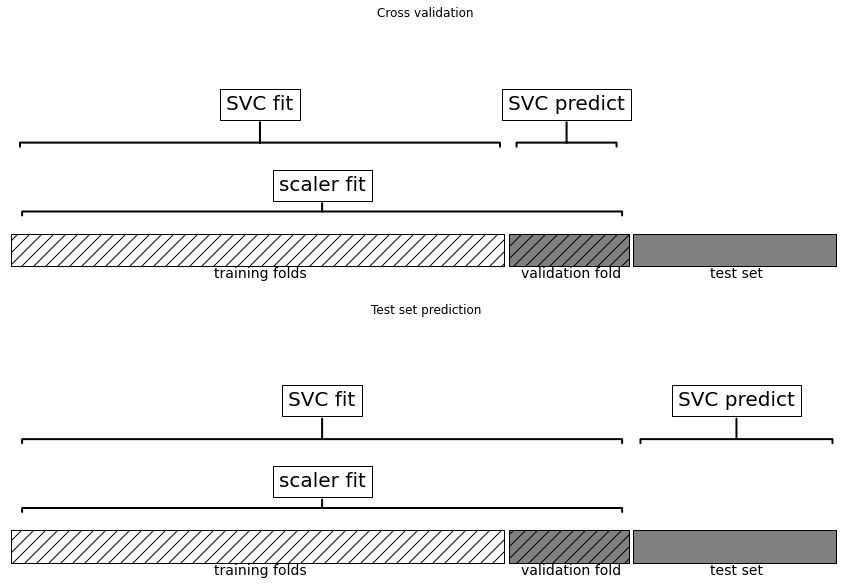

In [17]:
mglearn.plots.plot_improper_processing()

### Tworzenie potoków

In [18]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [20]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


### Używanie potoków w przeszukiwaniu siatki

In [21]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [23]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Najlepsza dokładność walidacji krzyżowej: {:.2f}".format(grid.best_score_))
print("Najlepszy wynik na zestawie testowym: {:.2f}".format(grid.score(X_test, y_test)))
print("Najlepsze parametry: {}".format(grid.best_params_))

Najlepsza dokładność walidacji krzyżowej: 0.98
Najlepszy wynik na zestawie testowym: 0.97
Najlepsze parametry: {'svm__C': 1, 'svm__gamma': 1}


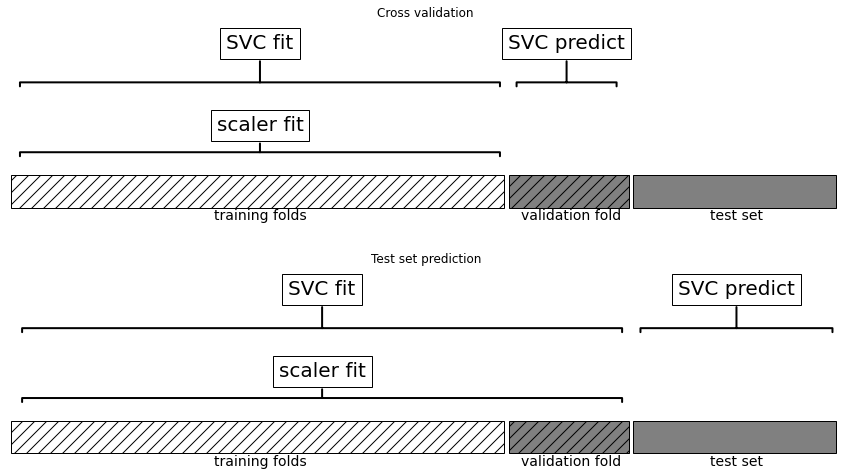

In [24]:
mglearn.plots.plot_proper_processing()

In [25]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [26]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


In [28]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


### Ogólny interfejs potoku

In [29]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iteruj po wszystkich krokach poza ostatnim
        # dopasuj i przekształć dane
        X_transformed = estimator.fit_transform(X_transformed, y)
    # dopasuj ostatni krok
    self.steps[-1][1].fit(X_transformed, y)
    return self


In [30]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iteruj po wszystkich krokach poza ostatnim
        # przekształć dane
        X_transformed = step[1].transform(X_transformed)
    # dopasuj ostatni krok
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

### Convenient Pipeline creation with ``make_pipeline``

In [31]:
from sklearn.pipeline import make_pipeline
# standardowa składnia
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# skrócona składnia
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [32]:
print("Kroki potoku:\n{}".format(pipe_short.steps))

Kroki potoku:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Kroki potoku:\n{}".format(pipe.steps))

Kroki potoku:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


#### Dostęp do atrybutów kroku

In [34]:
# dopasuj potok zdefiniowany wcześniej do zbioru danych cancer
pipe.fit(cancer.data)
# wyodrębnij pierwsze dwa główne komponenty z kroku "pca"
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Dostęp do atrybutów klasy GridSearchCV

In [35]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [36]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [38]:
print("Najlepszy estymator:\n{}".format(grid.best_estimator_))

Najlepszy estymator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [39]:
print("Krok regresji logistycznej:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Krok regresji logistycznej:
LogisticRegression(C=1, max_iter=1000)


In [40]:
print("Współczynniki regresji logistycznej:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Współczynniki regresji logistycznej:
[[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


### Kroki przetwarzania wstępnego przeszukiwania siatki i parametry modelu

In [41]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [42]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [43]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

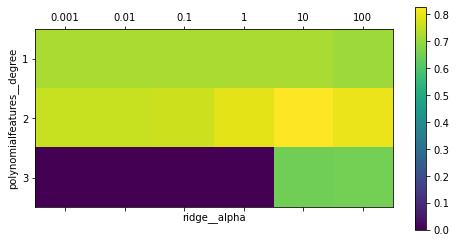

In [47]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

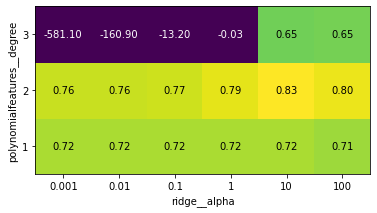

In [44]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [48]:
print("Najlepsze parametry: {}".format(grid.best_params_))

Najlepsze parametry: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [49]:
print("Wynik na zestawie testowym: {:.2f}".format(grid.score(X_test, y_test)))

Wynik na zestawie testowym: 0.77


In [50]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Wynik bez cech wielomianowych: {:.2f}".format(grid.score(X_test, y_test)))

Wynik bez cech wielomianowych: 0.63


In [53]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [54]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Najlepsze parametry:\n{}\n".format(grid.best_params_))
print("Najlepszy wynik walidacji krzyżowej: {:.2f}".format(grid.best_score_))
print("Wynik na zestawie testowym: {:.2f}".format(grid.score(X_test, y_test)))

Najlepsze parametry:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Najlepszy wynik walidacji krzyżowej: 0.99
Wynik na zestawie testowym: 0.98


#### Avoiding Redundant Computation

In [56]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")